    Time  GMSL
140 1880 -30.3
139 1881 -24.7
138 1882 -41.5
137 1883 -36.2
136 1884 -15.3
135 1885 -16.8


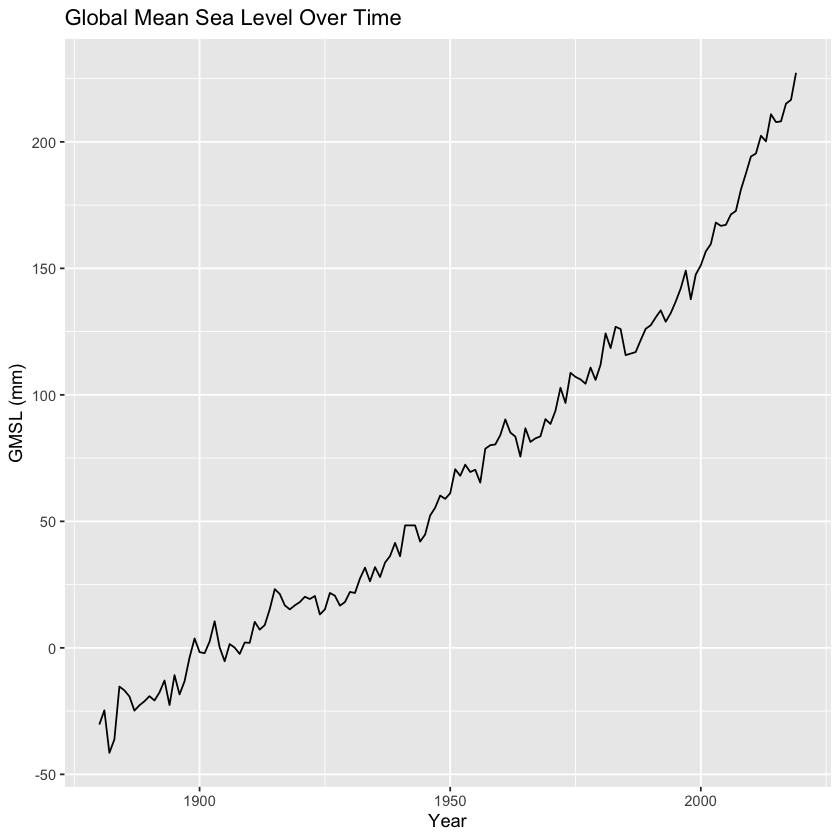

In [ ]:
# Load required libraries
library(tseries)
library(forecast)

# --- Step 1: Load the Data ---
gmsl_data <- read.csv("sea_level_data.csv", header = TRUE, stringsAsFactors = FALSE)

# Keep only Time and GMSL columns
gmsl_data <- gmsl_data[, c("Time", "GMSL")]

# Sort the data in ascending order by Time (1880 to 2019)
gmsl_data <- gmsl_data[order(gmsl_data$Time), ]

# Convert GMSL column to numeric (in case it's read as character)
gmsl_data$GMSL <- as.numeric(gmsl_data$GMSL)

# Create a time series object
gmsl_ts <- ts(gmsl_data$GMSL, start = min(gmsl_data$Time), frequency = 1)



# Plot the time series
autoplot(gmsl_ts) +
  ggtitle("Global Mean Sea Level Over Time") +
  xlab("Year") +
  ylab("GMSL (mm)")


Analysis of the Time Series Plot
The given plot represents the Global Mean Sea Level (GMSL) over time, showing an upward trend from around 1880 to 2019. However, we also observe variations in the fluctuations of the values, which suggests the presence of heteroscedasticity (changing variance over time). Since the values range from negative to positive, applying a log transformation is not straightforward.

In [11]:
lambda <- BoxCox.lambda(gmsl_ts)  # Automatically finds the best λ
gmsl_stabilized <- BoxCox(gmsl_ts, lambda)


Warning message in guerrero(x, lower, upper):
“Guerrero's method for selecting a Box-Cox parameter (lambda) is given for strictly positive data.”


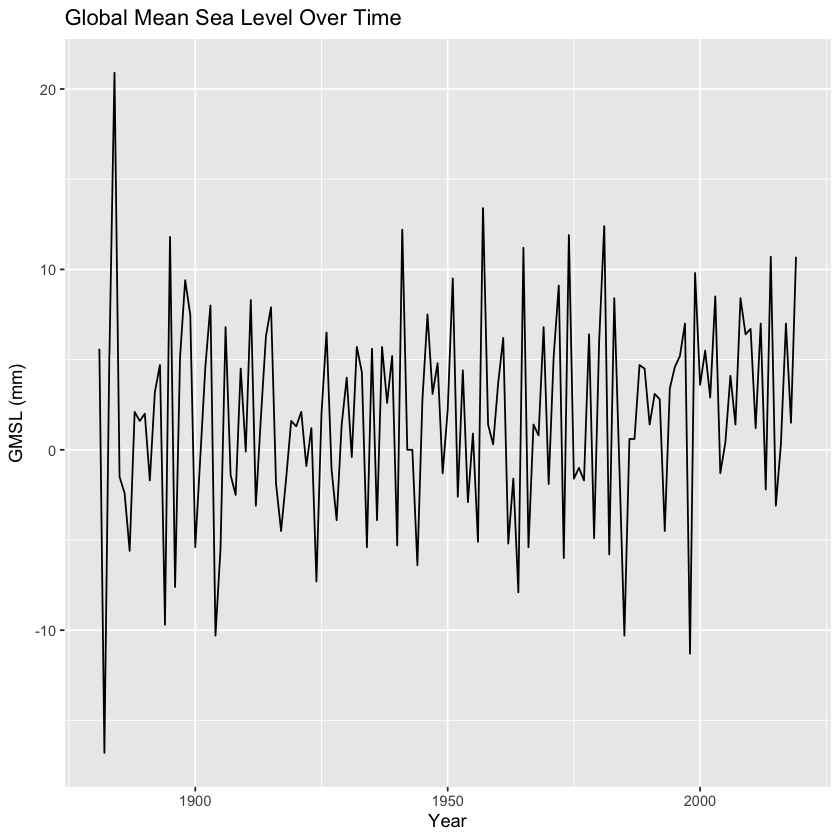

In [12]:
diff_gmsl <- diff(gmsl_ts)
# Plot the time series
autoplot(diff_gmsl) +
  ggtitle("Global Mean Sea Level Over Time") +
  xlab("Year") +
  ylab("GMSL (mm)")

In [13]:
adf.test(diff_gmsl)


Warning message in adf.test(diff_gmsl):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  diff_gmsl
Dickey-Fuller = -6.0394, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


 Augmented Dickey-Fuller (ADF) test results show that the first-differenced series is stationary

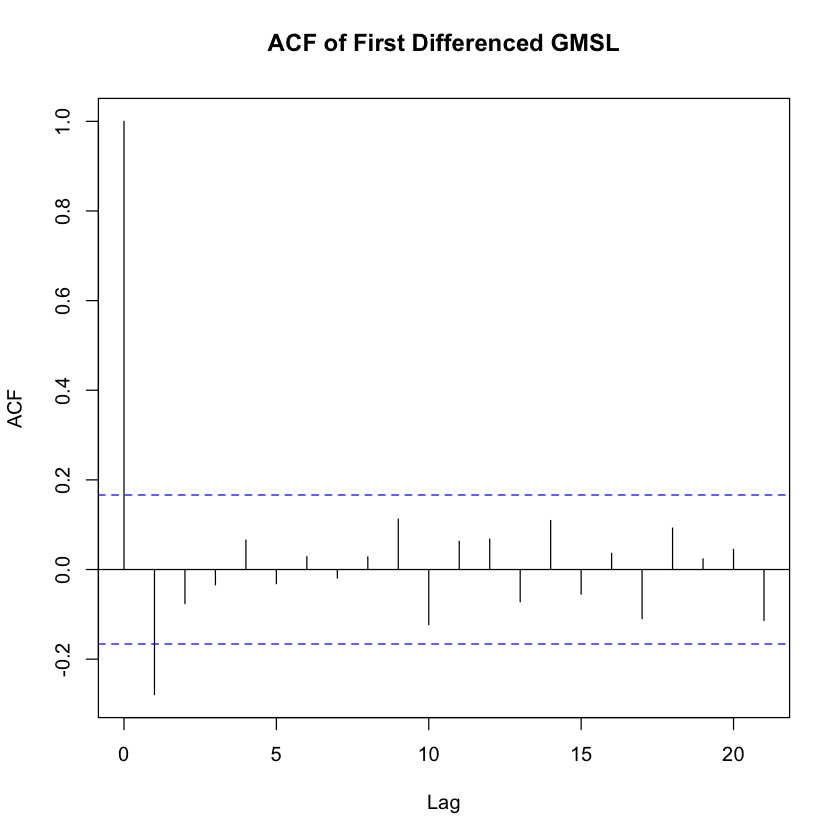

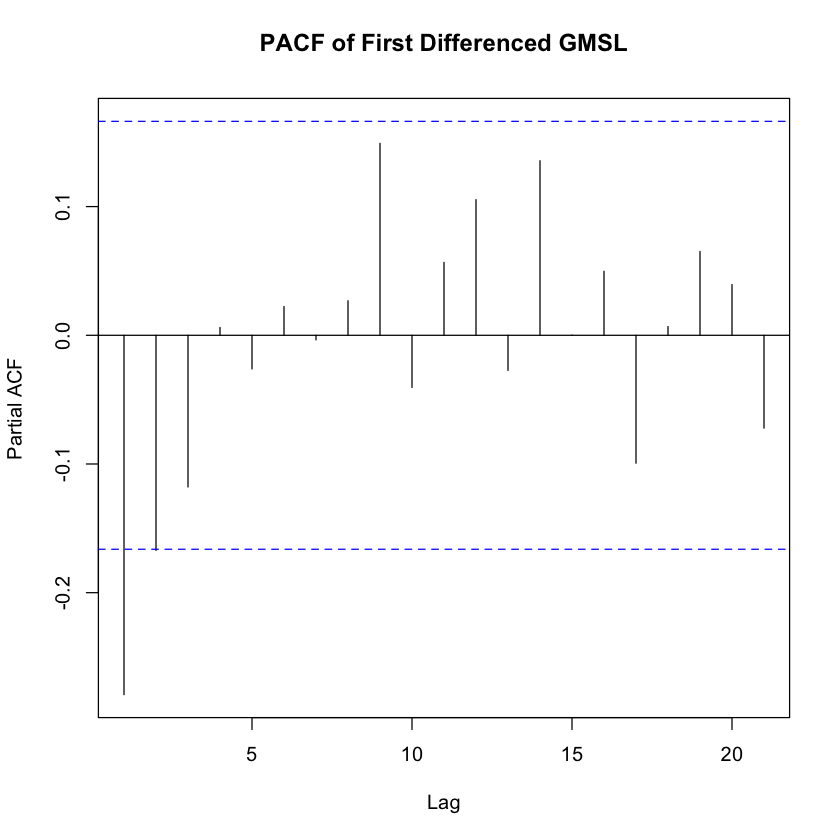

In [16]:
par(bg = "white")
acf(diff_gmsl, main = "ACF of First Differenced GMSL")
pacf(diff_gmsl, main = "PACF of First Differenced GMSL")


The ACF shows a significant spike at lag 1 and then cuts off, which suggests an MA(1) process.

The PACF shows a gradual decline rather than a sharp cutoff, which does not strongly indicate a pure AR model.

In [34]:
# Define training size (90% training, 10% testing)
train_size <- floor(0.9 * length(gmsl_ts))

# Create training and testing sets using differenced data
train_data <- window(gmsl_ts, end = time(gmsl_ts)[train_size])
test_data  <- window(gmsl_ts, start = time(gmsl_ts)[train_size + 1])

# Check the lengths
length(train_data); length(test_data)


[1] 126

[1] 14

In [35]:
forecast_arima <- function(train_data, test_data, order = c(0,1,1), title = "ARIMA Forecast vs Actual Data") {
  # Fit ARIMA model
  model <- arima(train_data, order = order)
  
  # Forecast for the length of the test set
  forecasted_values <- forecast(model, h = length(test_data))
  
  # Print forecast summary
  print(forecasted_values)
  
  # Plot the forecast vs actual values
  par(bg = "white")
  plot(forecasted_values, main = title)
  lines(test_data, col = "red", lwd = 2)  # Add actual values in red
  
  # Return the fitted model and forecasted values
  return(list(model = model, forecast = forecasted_values))
}




     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2006       167.0816 159.5592 174.6040 155.5771 178.5861
2007       167.0816 157.5137 176.6495 152.4487 181.7144
2008       167.0816 155.8342 178.3289 149.8802 184.2829
2009       167.0816 154.3748 179.7883 147.6483 186.5149
2010       167.0816 153.0666 181.0966 145.6475 188.5157
2011       167.0816 151.8704 182.2927 143.8181 190.3450
2012       167.0816 150.7617 183.4014 142.1225 192.0406
2013       167.0816 149.7237 184.4394 140.5350 193.6281
2014       167.0816 148.7443 185.4188 139.0372 195.1259
2015       167.0816 147.8147 186.3484 137.6154 196.5477
2016       167.0816 146.9279 187.2353 136.2592 197.9040
2017       167.0816 146.0785 188.0846 134.9601 199.2030
2018       167.0816 145.2621 188.9010 133.7116 200.4515
2019       167.0816 144.4752 189.6879 132.5082 201.6550


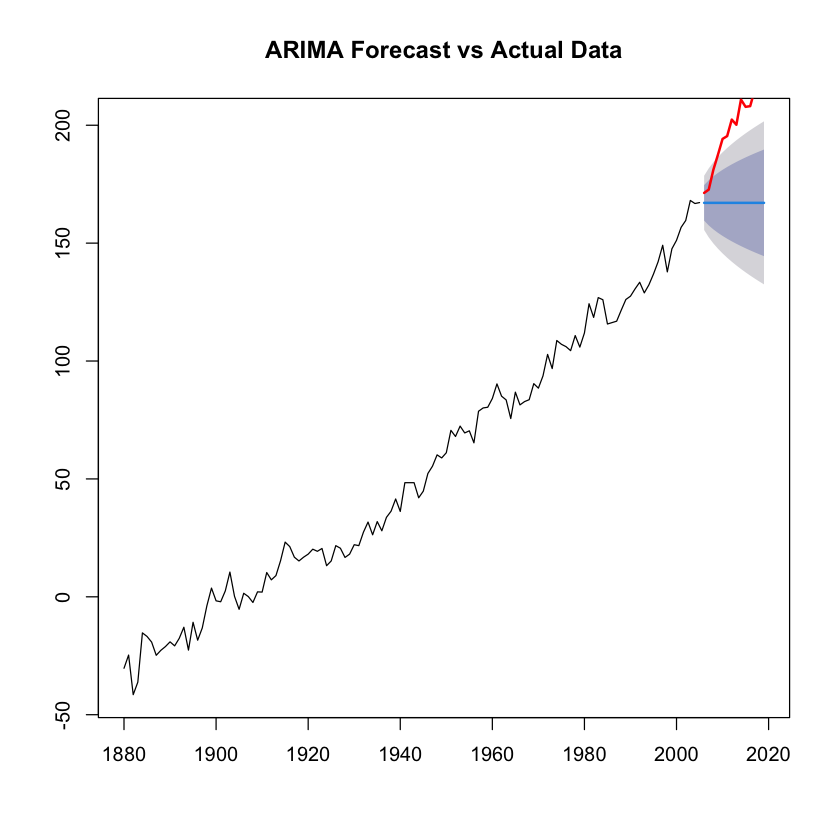

In [36]:
# Example usage with ARIMA(0,1,1)
results <- forecast_arima(train_data, test_data, order = c(0,1,1))

     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2006       167.0814 159.5590 174.6038 155.5769 178.5859
2007       167.0814 157.5133 176.6495 152.4482 181.7146
2008       167.0814 155.8339 178.3289 149.8798 184.2830
2009       167.0814 154.3746 179.7882 147.6480 186.5148
2010       167.0814 153.0664 181.0964 145.6473 188.5155
2011       167.0814 151.8703 182.2925 143.8181 190.3447
2012       167.0814 150.7617 183.4011 142.1225 192.0403
2013       167.0814 149.7237 184.4391 140.5350 193.6278
2014       167.0814 148.7443 185.4185 139.0373 195.1255
2015       167.0814 147.8147 186.3481 137.6156 196.5472
2016       167.0814 146.9279 187.2349 136.2593 197.9035
2017       167.0814 146.0786 188.0842 134.9603 199.2025
2018       167.0814 145.2622 188.9006 133.7119 200.4509
2019       167.0814 144.4754 189.6874 132.5085 201.6543


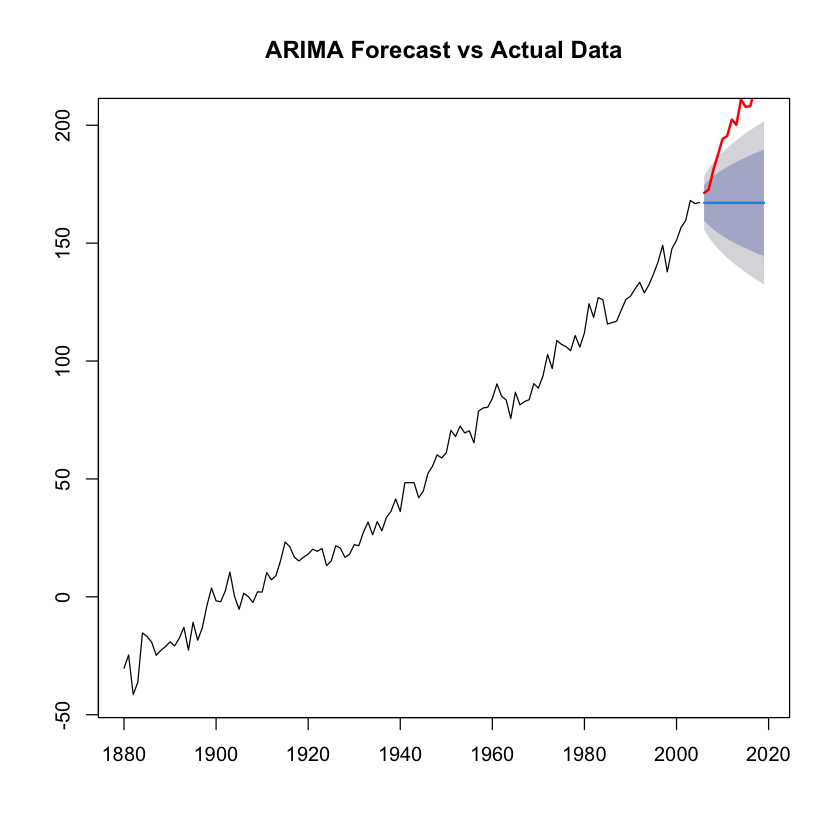

In [37]:
# Example usage with ARIMA(0,1,1)
results <- forecast_arima(train_data, test_data, order = c(1,1,1))

In [38]:
best_model <- auto.arima(train_data)
summary(best_model)

Series: train_data 
ARIMA(1,1,1) with drift 

Coefficients:
         ar1      ma1   drift
      0.3199  -0.7301  1.5784
s.e.  0.1666   0.1243  0.1924

sigma^2 = 28.9:  log likelihood = -386.25
AIC=780.49   AICc=780.83   BIC=791.81

Training set error measures:
                      ME   RMSE      MAE      MPE     MAPE      MASE
Training set -0.02181072 5.2894 4.157697 -63.8309 90.12261 0.8703939
                    ACF1
Training set 0.003198208


Call:
arima(x = train_ts, order = c(1, 1, 1))

Coefficients:
         ar1      ma1
      0.0003  -0.2143
s.e.  0.2910   0.2768

sigma^2 estimated as 34.45:  log likelihood = -398.62,  aic = 803.23
     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2006       167.0814 159.5590 174.6038 155.5769 178.5859
2007       167.0814 157.5133 176.6495 152.4482 181.7146
2008       167.0814 155.8339 178.3289 149.8798 184.2830
2009       167.0814 154.3746 179.7882 147.6480 186.5148
2010       167.0814 153.0664 181.0964 145.6473 188.5155
2011       167.0814 151.8703 182.2925 143.8181 190.3447
2012       167.0814 150.7617 183.4011 142.1225 192.0403
2013       167.0814 149.7237 184.4391 140.5350 193.6278
2014       167.0814 148.7443 185.4185 139.0373 195.1255
2015       167.0814 147.8147 186.3481 137.6156 196.5472
2016       167.0814 146.9279 187.2349 136.2593 197.9035
2017       167.0814 146.0786 188.0842 134.9603 199.2025
2018       167.0814 145.2622 188.9006 133.7119 200.4509
2019       167.081

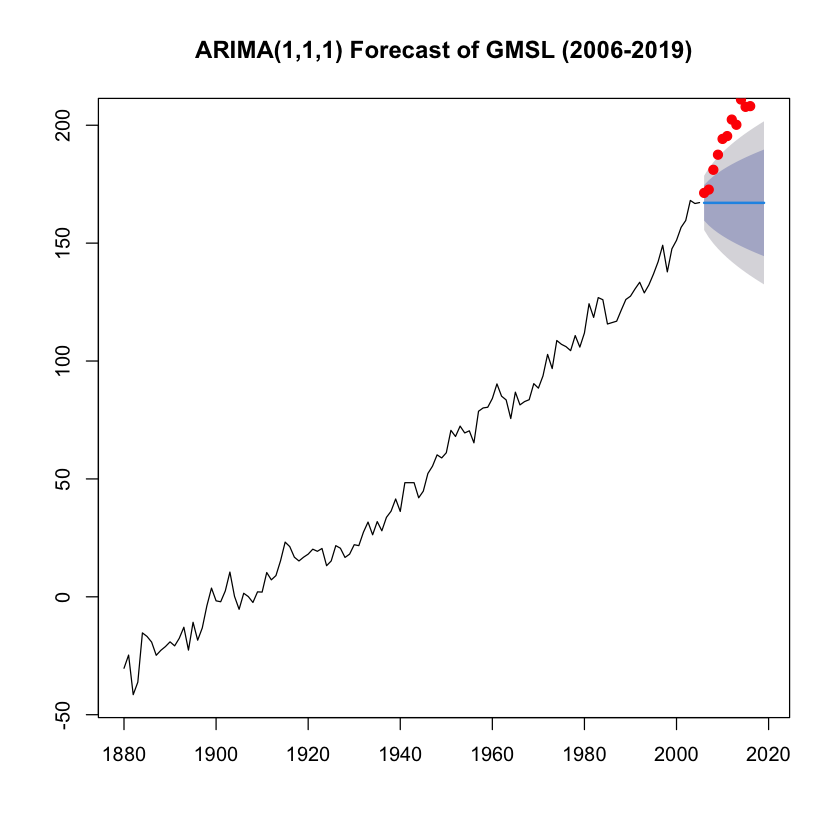

In [41]:
# Assume training data ends at 2005 as per your forecast output
train_ts <- window(gmsl_ts, end = 2005)

# Fit ARIMA(1,1,1)
model <- arima(train_ts, order = c(1,1,1))

# Check model parameters
print(model)

# Forecast 14 steps ahead (2006-2019)
forecasts <- forecast(model, h = 14)
print(forecasts)

# Plot forecasts
plot(forecasts, main = "ARIMA(1,1,1) Forecast of GMSL (2006-2019)")
points(2006:2019, window(gmsl_ts, start = 2006), col = "red", pch = 19)

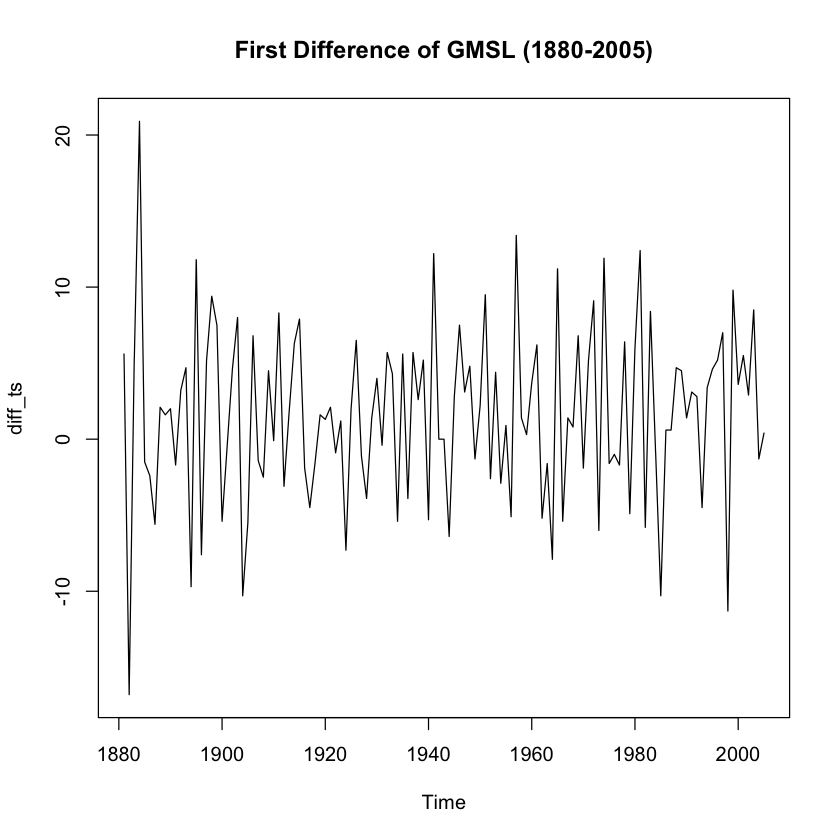

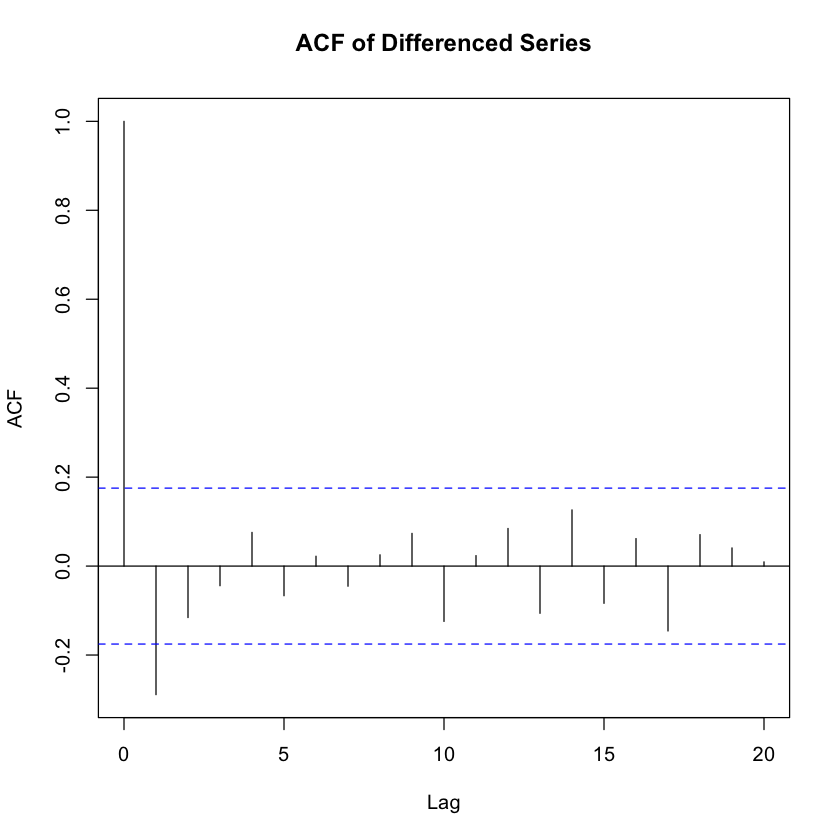

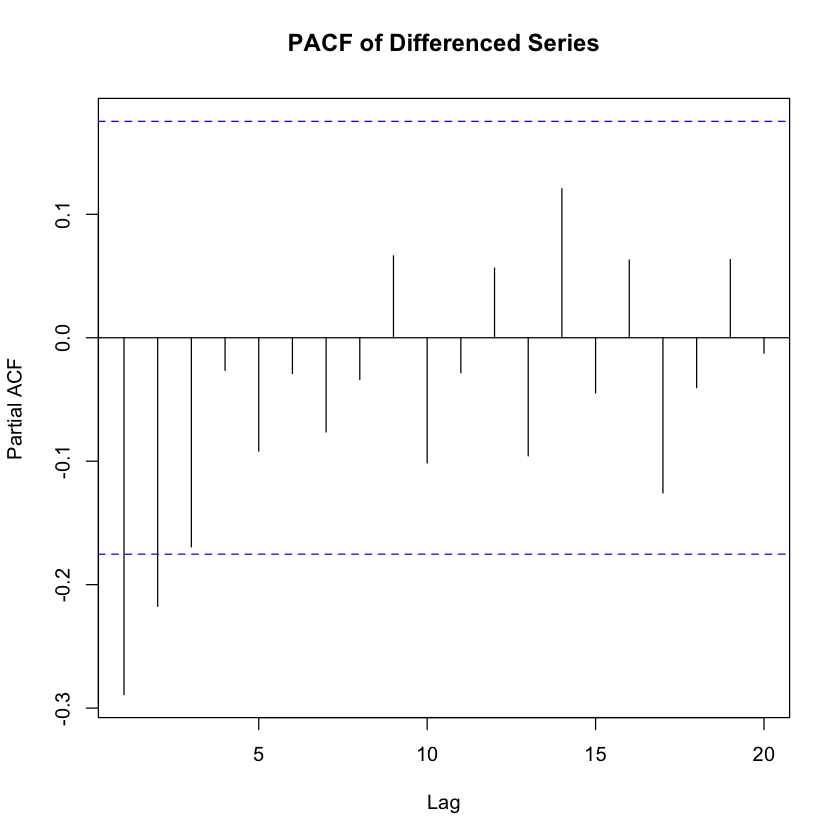

In [42]:
diff_ts <- diff(train_ts)
par(bg = "white")
plot(diff_ts, main = "First Difference of GMSL (1880-2005)")
acf(diff_ts, main = "ACF of Differenced Series")
pacf(diff_ts, main = "PACF of Differenced Series")



Call:
arima(x = train_ts, order = c(1, 1, 0))

Coefficients:
          ar1
      -0.2012
s.e.   0.0875

sigma^2 estimated as 34.58:  log likelihood = -398.85,  aic = 801.69
     Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2006       167.1195 159.5832 174.6558 155.5937 178.6453
2007       167.1357 157.4902 176.7812 152.3842 181.8873
2008       167.1325 155.5980 178.6669 149.4921 184.7728
2009       167.1331 154.0077 180.2585 147.0595 187.2067
2010       167.1330 152.5843 181.6817 144.8827 189.3833
2011       167.1330 151.2893 182.9767 142.9022 191.3638
2012       167.1330 150.0923 184.1737 141.0715 193.1945
2013       167.1330 148.9740 185.2920 139.3613 194.9047
2014       167.1330 147.9207 186.3452 137.7504 196.5156
2015       167.1330 146.9223 187.3437 136.2234 198.0426
2016       167.1330 145.9709 188.2951 134.7683 199.4977
2017       167.1330 145.0604 189.2056 133.3759 200.8901
2018       167.1330 144.1861 190.0799 132.0387 202.2273
2019       167.1330 143.3439 190.9221 130.

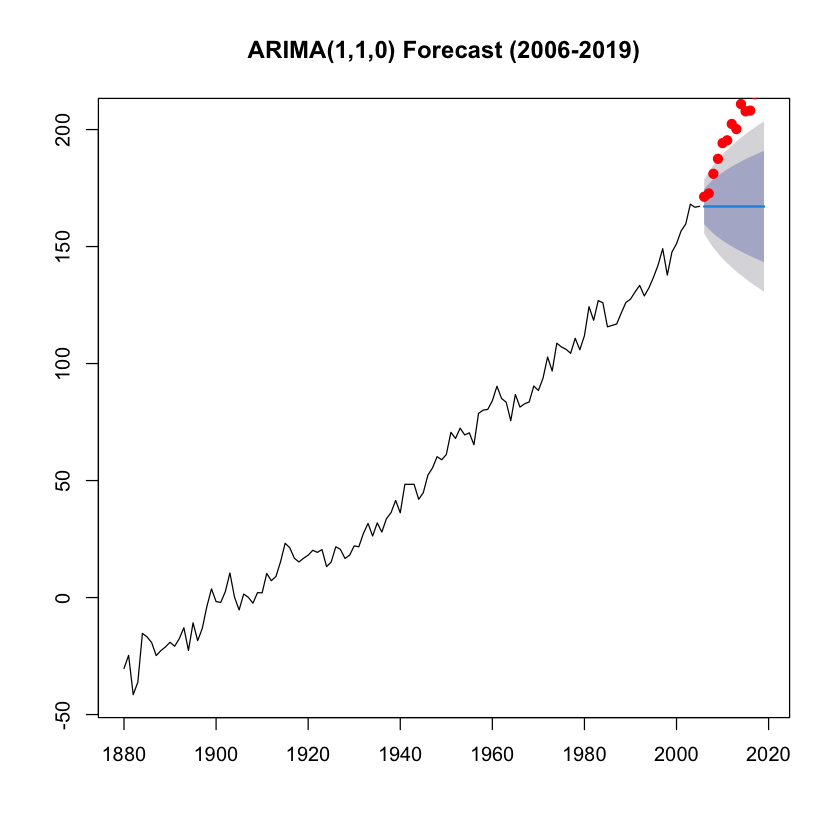

In [43]:
# Fit ARIMA(1,1,0)
model_arima110 <- arima(train_ts, order = c(1,1,0))
print(model_arima110)

# Forecast
forecasts_110 <- forecast(model_arima110, h = 14)
print(forecasts_110)
plot(forecasts_110, main = "ARIMA(1,1,0) Forecast (2006-2019)")
points(2006:2019, window(gmsl_ts, start = 2006), col = "red", pch = 19)

In [44]:
model_drift <- arima(train_ts, order = c(1,1,0), include.drift = TRUE)
print(model_drift)

forecasts_drift <- forecast(model_drift, h = 14)
print(forecasts_drift)
plot(forecasts_drift, main = "ARIMA(1,1,0) with Drift Forecast (2006-2019)")
points(2006:2019, window(gmsl_ts, start = 2006), col = "red", pch = 19)

ERROR: Error in arima(train_ts, order = c(1, 1, 0), include.drift = TRUE): unused argument (include.drift = TRUE)


Series: train_ts 
ARIMA(1,1,1) with drift 

Coefficients:
         ar1      ma1   drift
      0.3199  -0.7301  1.5784
s.e.  0.1666   0.1243  0.1924

sigma^2 = 28.9:  log likelihood = -386.25
AIC=780.49   AICc=780.83   BIC=791.81


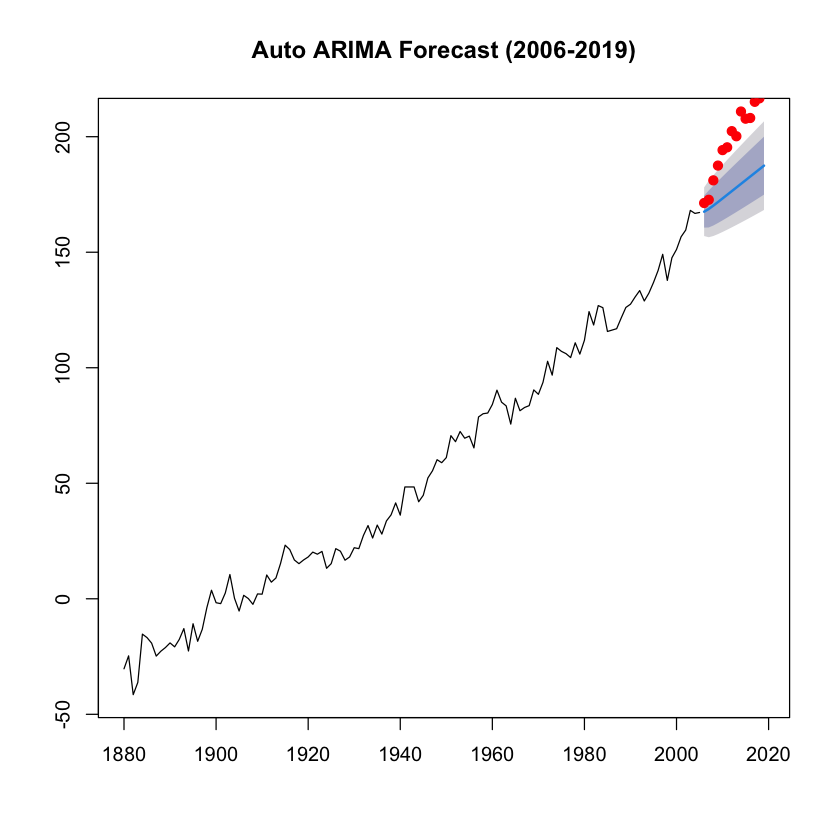

In [48]:
auto_model <- auto.arima(train_ts)
print(auto_model)

forecasts_auto <- forecast(auto_model, h = 14)
par(bg = "white")
plot(forecasts_auto, main = "Auto ARIMA Forecast (2006-2019)")
points(2006:2019, window(gmsl_ts, start = 2006), col = "red", pch = 19)

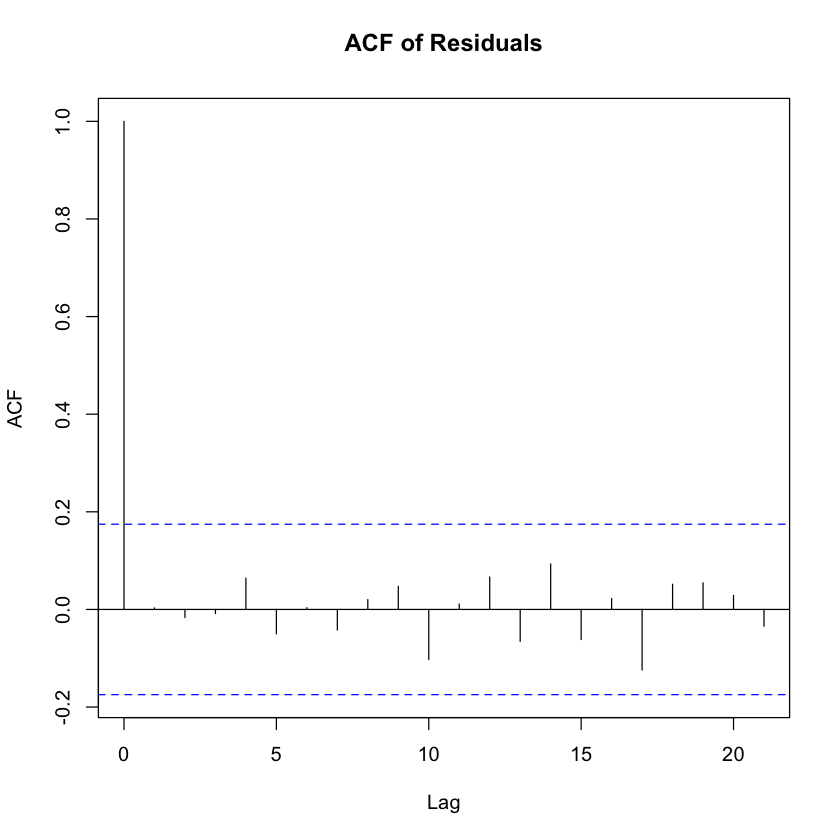


	Box-Ljung test

data:  residuals
X-squared = 2.9969, df = 10, p-value = 0.9815


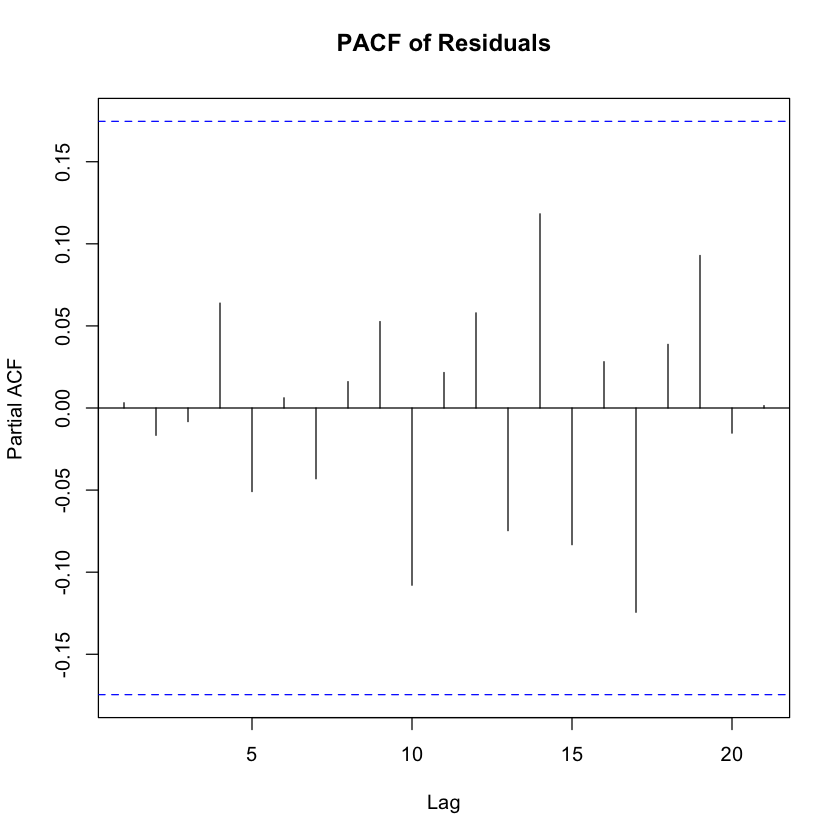

In [49]:
residuals <- residuals(auto_model)
par(bg = "white")
acf(residuals, main = "ACF of Residuals")
pacf(residuals, main = "PACF of Residuals")
Box.test(residuals, lag = 10, type = "Ljung-Box")